<a href="https://colab.research.google.com/github/Justype/colab-utils/blob/main/download/GDC-files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown # GDC Files Info Downloader
#@markdown <a href="https://portal.gdc.cancer.gov/"><img height="40" alt="GDC" src="https://th.bing.com/th/id/OIP.75uchrDzulWq6dZ8Lf3MFwAAAA?rs=1&pid=ImgDetMain"/></a>

#@markdown This script will not only get **file id** but also case **demographic info** (gender, race, age)
#@markdown and **diagnosic info** (tissue type, tumor descriptor).

#@markdown ---

#@markdown ## How it works?
#@markdown #### GET or POST using GDC RESTful API
#@markdown - GDC Documents: https://docs.gdc.cancer.gov/API/Users_Guide/Getting_Started/
#@markdown - Files field names: https://docs.gdc.cancer.gov/API/Users_Guide/Appendix_A_Available_Fields/#file-fields
#@markdown   - First POST: `size : 1` - to get totoal count
#@markdown   - Second POST `size : total count` - to get all file info

#@markdown ## ❗Please run this chunk first to set it up❗

import requests
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def get_files_by_filters(filters):
  """
  Retrieves files and meta info from the GDC API based on the provided filters.

  Please use filters from the GDC API:
  https://docs.gdc.cancer.gov/API/Users_Guide/Appendix_A_Available_Fields/#file-fields
  """
  # GDC API endpoint for files
  url = "https://api.gdc.cancer.gov/files"

  output_fields = [
    "file_id", "access", "file_name", "data_type", "data_category", "data_format",
    "experimental_strategy", "platform", "analysis.workflow_type", # BWA STAR ...
    "cases.case_id", "cases.submitter_id", "cases.samples.tissue_type", # normal or tumor
    "cases.samples.tumor_descriptor", # primary, recurrence or ...
    "cases.project.project_id", "cases.project.program.name",
    # Demographic Info
    "cases.demographic.demographic_id", "cases.demographic.ethnicity",
    "cases.demographic.gender", "cases.demographic.race",
    "cases.demographic.year_of_birth", "cases.demographic.year_of_death",
    "cases.demographic.days_to_birth", "cases.demographic.days_to_death",
    "cases.demographic.vital_status",
    # Diagnosis Info
    "cases.diagnoses.diagnosis_id", "cases.diagnoses.age_at_diagnosis",
    "cases.diagnoses.classification_of_tumor", "cases.diagnoses.days_to_recurrence",
    "cases.diagnoses.morphology", "cases.diagnoses.primary_diagnosis",
    "cases.diagnoses.progression_or_recurrence", "cases.diagnoses.updated_datetime"
  ]

  size = 1  # 1 first to retrive total size

  while(True):
    # Query parameters
    payload = {
        "filters": filters,
        "fields": ",".join(output_fields),
        "format": "JSON",
        "size": size
    }

    response = requests.post(url, json=payload)
    if response.status_code != 200:
      print(f"Error: {response.status_code}, {response.text}")
      return None

    files = response.json()
    if size == 1:
      size = files["data"]["pagination"]["total"]
      if size == 0:
        print("No files found!")
        return []
      print(f"Total Files: {size}, Retriving info...")
      continue

    print("Downloaded!")
    return (files["data"]["hits"])

def parse_files_as_df(files):
  """
  Parse Files Json to Pandas DataFrame
  """
  data = pd.DataFrame()
  print("Parsing file info to DataFrame...")
  for file in files:
    try:
      data.loc[file["id"], "file_id"] = file["file_id"]
      data.loc[file["id"], "access"] = file["access"]
      data.loc[file["id"], "file_name"] = file["file_name"]
      data.loc[file["id"], "experimental_strategy"] = file["experimental_strategy"]
      data.loc[file["id"], "data_type"] = file["data_type"]
      data.loc[file["id"], "data_format"] = file["data_format"]
      data.loc[file["id"], "data_format"] = file["data_format"]
      data.loc[file["id"], "data_category"] = file["data_category"]
      data.loc[file["id"], "platform"] = file["platform"]
      data.loc[file["id"], "workflow_type"] = file["analysis"]["workflow_type"] # BWA STAR ...
      # Case Info
      if len(file["cases"]) > 1:
        print("Warning: Multiple cases in file_id:", file["id"], "Only using first case")
      data.loc[file["id"], "case_id"] = file["cases"][0]["case_id"]
      data.loc[file["id"], "submitter_id"] = file["cases"][0]["submitter_id"] # TCGA-14-3476
      data.loc[file["id"], "tissue_type"] = file["cases"][0]["samples"][0]["tissue_type"] # normal or tumor
      data.loc[file["id"], "tumor_descriptor"] = file["cases"][0]["samples"][0]["tumor_descriptor"] # primary, recurrence or ...
      data.loc[file["id"], "project_id"] = file["cases"][0]["project"]["project_id"]
      data.loc[file["id"], "program_name"] = file["cases"][0]["project"]["program"]["name"]
      if "demographic" in file["cases"][0]: # Demographic Info
        data.loc[file["id"], "demographic_id"] = file["cases"][0]["demographic"]["demographic_id"]
        data.loc[file["id"], "ethnicity"] = file["cases"][0]["demographic"]["ethnicity"]
        data.loc[file["id"], "gender"] = file["cases"][0]["demographic"]["gender"]
        data.loc[file["id"], "race"] = file["cases"][0]["demographic"]["race"]
        data.loc[file["id"], "year_of_birth"] = file["cases"][0]["demographic"]["year_of_birth"]
        data.loc[file["id"], "year_of_death"] = file["cases"][0]["demographic"]["year_of_death"]
        if "vital_status" in file["cases"][0]["demographic"]:
          data.loc[file["id"], "vital_status"] = file["cases"][0]["demographic"]["vital_status"]
        # if "days_to_birth" in file["cases"][0]["demographic"]:
        #   data.loc[file["id"], "days_to_birth"] = file["cases"][0]["demographic"]["days_to_birth"]
        if "days_to_death" in file["cases"][0]["demographic"]:
          data.loc[file["id"], "days_to_death"] = file["cases"][0]["demographic"]["days_to_death"]
      if "diagnoses" in file["cases"][0]: # Diagnosis info
        if len(file["cases"][0]["diagnoses"]) > 1:
          print("Warning: Multiple diagnoses in file_id:", file["id"], "Only using first diagnosis")
        data.loc[file["id"], "diagnosis_id"] = file["cases"][0]["diagnoses"][0]["diagnosis_id"]
        data.loc[file["id"], "age_at_diagnosis(days)"] = file["cases"][0]["diagnoses"][0]["age_at_diagnosis"]
        data.loc[file["id"], "diagnosis_datetime"] = file["cases"][0]["diagnoses"][0]["updated_datetime"]
        data.loc[file["id"], "classification_of_tumor"] = file["cases"][0]["diagnoses"][0]["classification_of_tumor"]
        data.loc[file["id"], "days_to_recurrence"] = file["cases"][0]["diagnoses"][0]["days_to_recurrence"]
        data.loc[file["id"], "primary_diagnosis"] = file["cases"][0]["diagnoses"][0]["primary_diagnosis"]
        data.loc[file["id"], "progression_or_recurrence"] = file["cases"][0]["diagnoses"][0]["progression_or_recurrence"]
    except Exception as e:
      print("Error in file_id:", file["id"])
      continue

  print("Parsing done!")
  return data


### Setting and Retrieving

[GDC Data Portal Repository](https://portal.gdc.cancer.gov/analysis_page?app=Downloads)

---

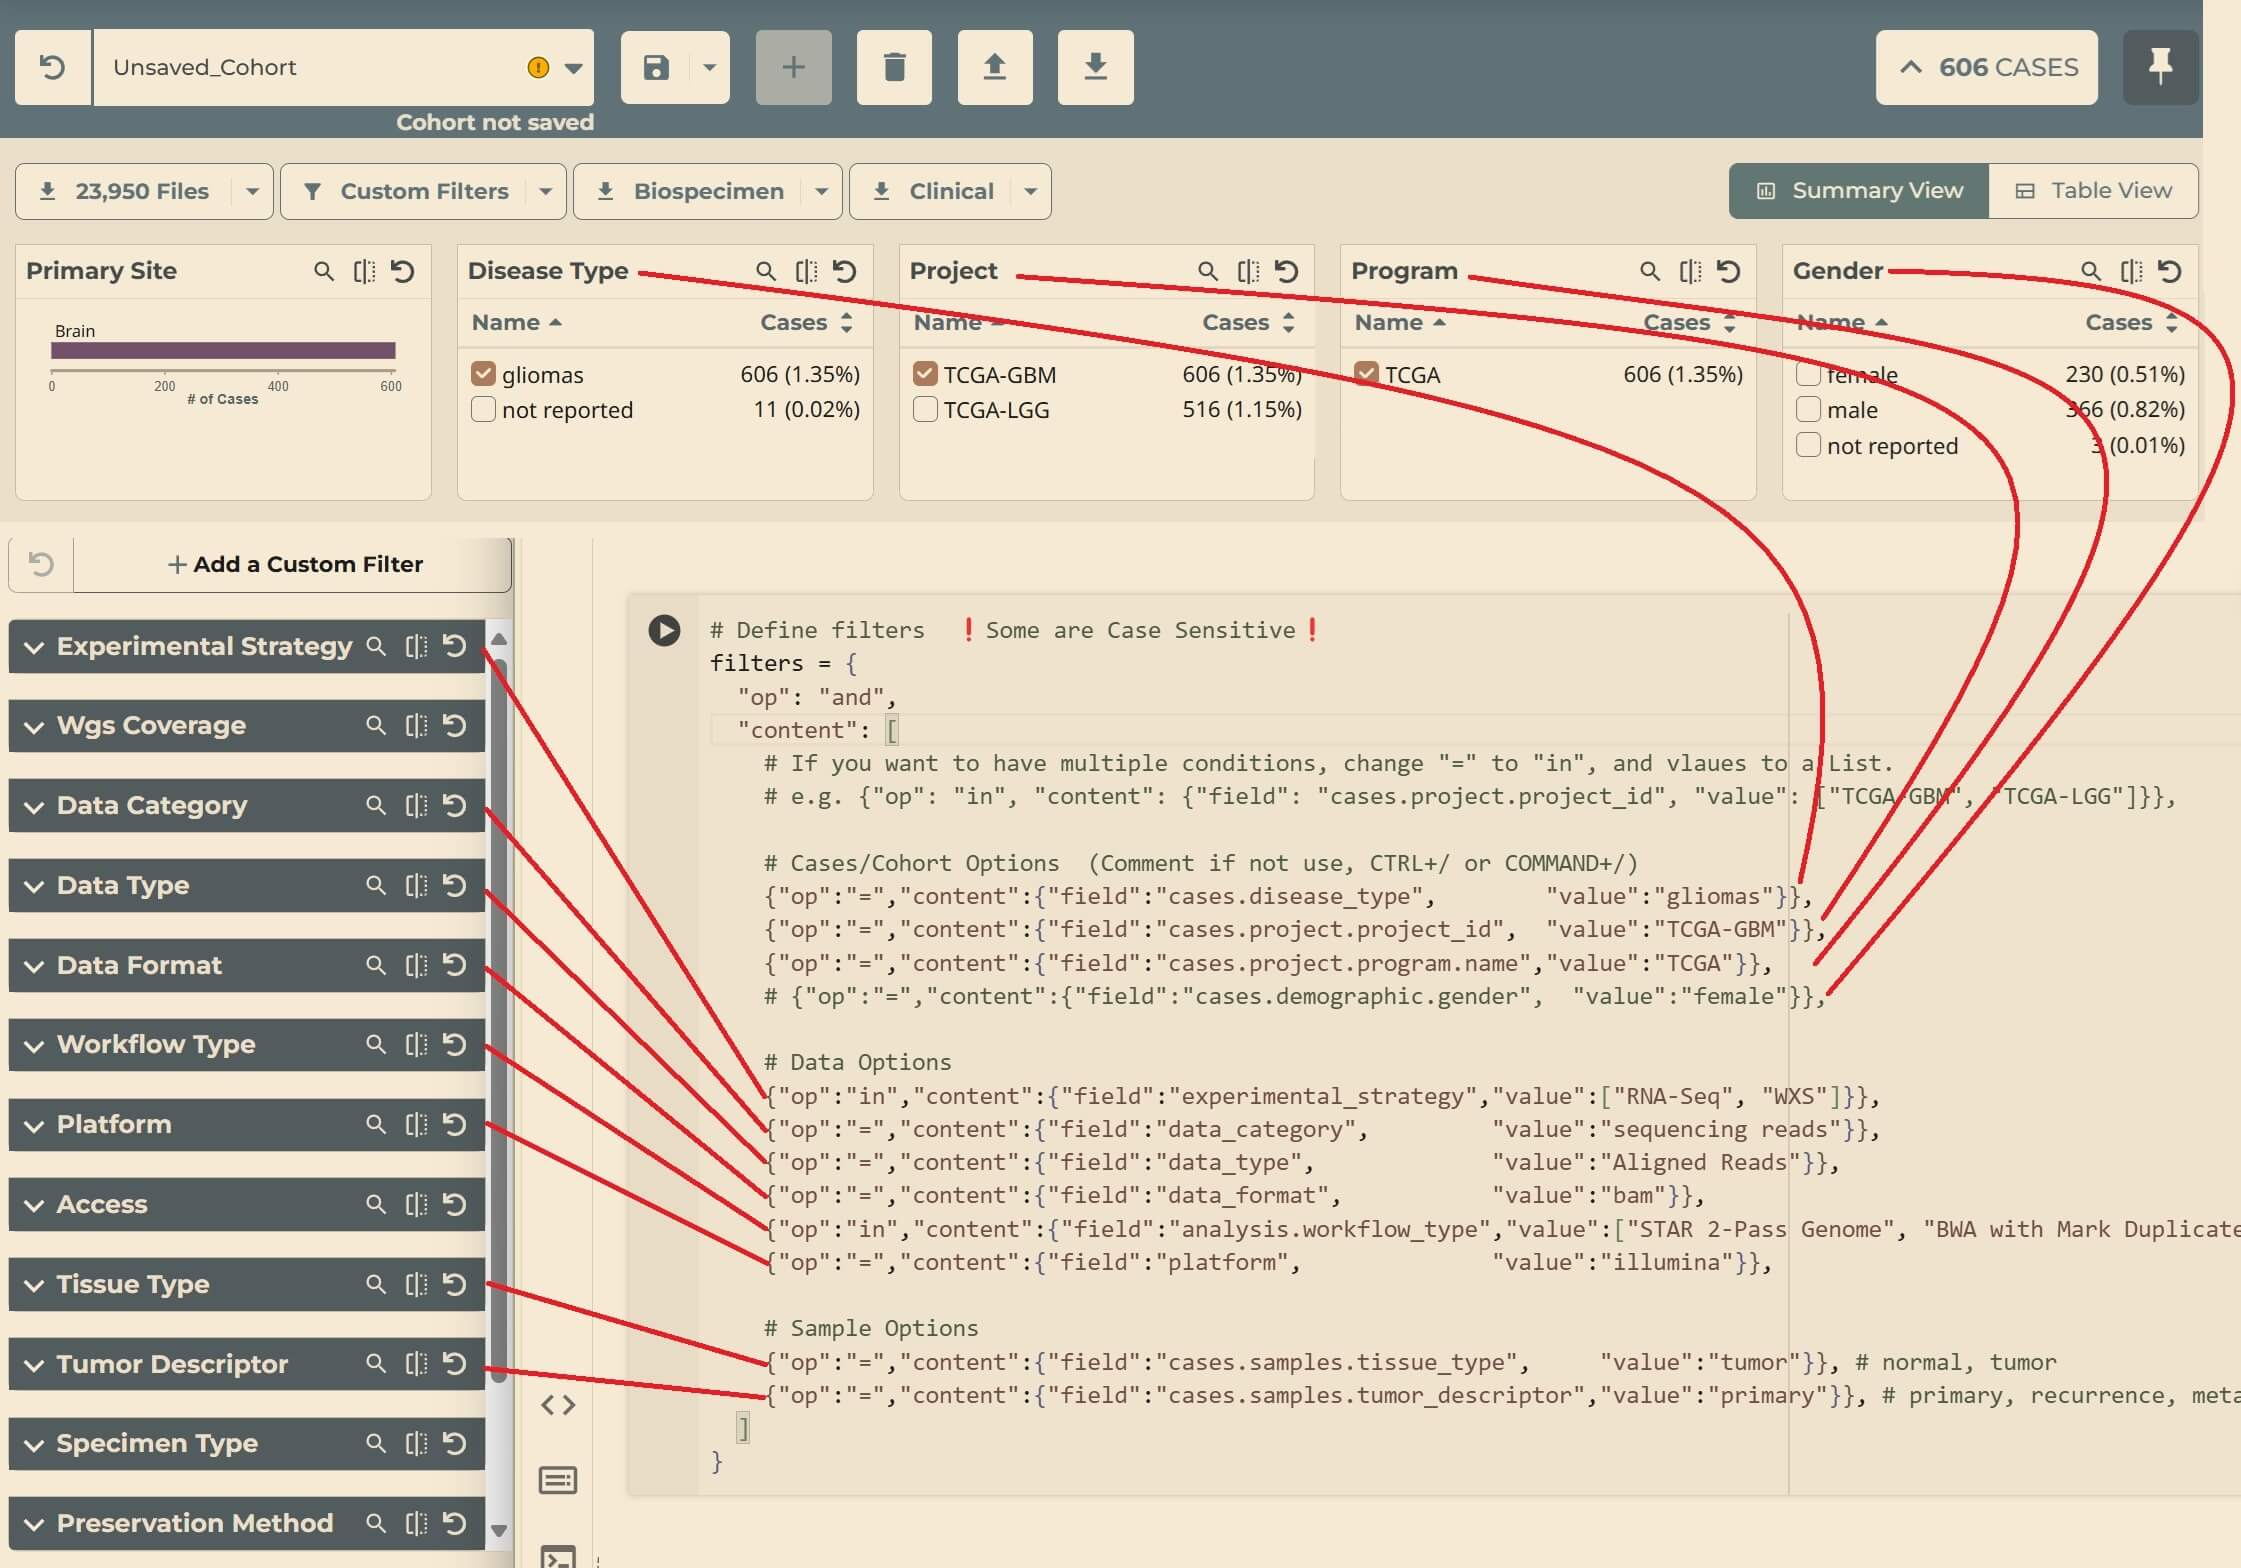

In [ ]:
# Define filters  ❗Some are Case Sensitive❗
filters = {
  "op": "and",
  "content": [
    # If you want to have multiple conditions, change "=" to "in", and change vlaues to a List.
    # e.g. {"op": "in", "content": {"field": "cases.project.project_id", "value": ["TCGA-GBM", "TCGA-LGG"]}},

    # Cases/Cohort Options  (Comment if not use, CTRL+/ or COMMAND+/)
    {"op":"=","content":{"field":"cases.disease_type",        "value":"gliomas"}},
    {"op":"=","content":{"field":"cases.project.project_id",  "value":"TCGA-GBM"}},
    # {"op":"=","content":{"field":"cases.project.program.name","value":"TCGA"}},
    # {"op":"=","content":{"field":"cases.demographic.gender",  "value":"female"}},

    # Data Options
    {"op":"in","content":{"field":"experimental_strategy","value":["RNA-Seq"]}},
    # {"op":"=","content":{"field":"data_category",         "value":"sequencing reads"}},
    # {"op":"=","content":{"field":"data_type",             "value":"Aligned Reads"}},
    {"op":"=","content":{"field":"data_format",           "value":"bam"}},
    {"op":"in","content":{"field":"analysis.workflow_type","value":["STAR 2-Pass Genome"]}},
    # {"op":"=","content":{"field":"platform",              "value":"illumina"}},

    # Sample Options
    # {"op":"=","content":{"field":"cases.samples.tissue_type",     "value":"tumor"}}, # normal, tumor
    # {"op":"=","content":{"field":"cases.samples.tumor_descriptor","value":"primary"}}, # primary, recurrence, metastatic ...
  ]
}

In [ ]:
#@markdown # Retrieving and Parsing Response
#@markdown # 👨‍✈️ 🛫✈️🛬📦😸

#@markdown NOTE: `-1` means `NA` in `year_of_birth`, `year_of_death`, and `age_at_diagnosis(days)` columns

#@markdown OUTPUT: `gdc_files.csv`
import numpy as np
files = get_files_by_filters(filters)
df = parse_files_as_df(files)
df = df.reset_index(drop=True) # reset index

# Convert NA to -1 on fload64 columns, then convert to int
for col in df.columns:
  if df[col].dtype == "float64":
    df[col] = df[col].replace(np.nan, -1)
    df[col] = df[col].astype(int)

df.to_csv("gdc_files.csv", index=False)
print(f"DataFrame successfully written to gdc_files.csv")

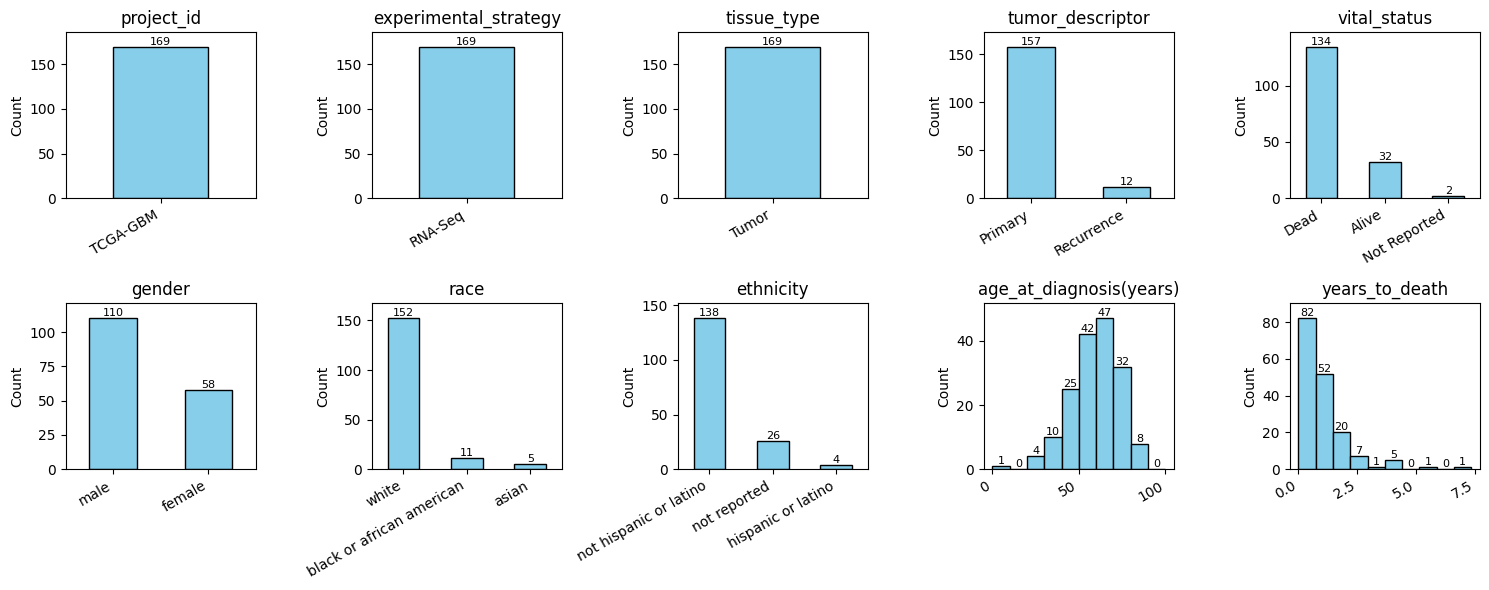

In [154]:
#@markdown # Summary Plots 📊
#@markdown # 👷‍♀️👷🏻‍♀️👷🏼‍♀️👷🏽‍♀️👷🏾‍♀️👷🏿‍♀️👷‍♂️👷🏻‍♂️👷🏼‍♂️👷🏽‍♂️👷🏾‍♂️👷🏿‍♂️

df["age_at_diagnosis(years)"] = df["age_at_diagnosis(days)"].apply(lambda x: int(x/365))
df["years_to_death"] = df["days_to_death"].apply(lambda x: x/365)

col_to_plot = ['project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status',
               'gender', 'race', 'ethnicity', 'age_at_diagnosis(years)', "years_to_death"]

# Create a grid for plotting
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2x5 grid
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each column
for i, col in enumerate(col_to_plot):
    # Get the axes for the current subplot
    ax = axes[i]

    if df[col].dtype in ["int64", "float64"]:
        # Create histogram plot
        if col == 'age_at_diagnosis(years)':
          n, bins, patches = ax.hist(df[col], bins=np.arange(0, 110, 10), color='skyblue', edgecolor='black')
        else:
          n, bins, patches = ax.hist(df[col][df[col] != -1], bins=10, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.bar_label(patches, fontsize=8) # Add labels to the histogram bins
        ax.set_ylim(0, max(n) * 1.1)  # 10% y axis padding
    else:
        # Create bar plot
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.bar_label(ax.containers[0], fontsize=8)  # Add labels to the bars

        # Add padding at the top of the y-axis
        ax.set_ylim(0, value_counts.max() * 1.1)  # 10% padding
    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Turn off any empty subplots if col_to_plot < 8
for j in range(len(col_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Do whatever you want to df: drop rows, filter
print(df.shape)

# drop not reported races
df = df[df['race'] != 'not reported']
df = df[df['vital_status'] != 'Not Repored']

print(df.shape)

# Sampling

In [ ]:
#@markdown # Sampling Option 1 🧌
#@markdown #### Select $n$ samples from each group by selected criteria (leave it blank if not use)

n_samples = 5 # @param {"type":"integer","placeholder":"number of samples"}
#@markdown #### Criteria:
group1 = "race" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group2 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group3 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
#@markdown #### Stratified by:
group4 = "vital_status" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group5 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
random_state = 42 # @param {"type":"integer","placeholder":"random state"}

groups = []
stratified = []

if group1 != "":
  groups.append(group1)
if group2 != "":
  groups.append(group2)
if group3 != "":
  groups.append(group3)
if group4 != "":
  stratified.append(group4)
if group5 != "":
  stratified.append(group5)

#@markdown #### ❗Rows whose group values have `NA` will be dropped before sampling❗
df1 = df.dropna(subset=groups)
df1 = df1.dropna(subset=stratified)

def split_df(df, n_samples, groups, stratified, random_state):
  if df.shape[0] <= n_samples: # If the group has less than n_samples, return all
    print("WARNING: Group", df[groups].value_counts().index.to_list()[0], "has less than or equal to", n_samples, "samples! Use all samples instead!")
    return df
  if stratified == []: # Simple Random Sampling
    return df.sample(n_samples, random_state=random_state)
  else: # Stratified Sampling
    from sklearn.model_selection import train_test_split
    try:
      df_return = train_test_split(df, test_size=n_samples, stratify=df[stratified],random_state=random_state)[1]
    except ValueError as e:
      print("WARNING: Stratification is not possible in group", df[groups].value_counts().index.to_list()[0], "! Use simple random instead!")
      df_return = df.sample(n_samples, random_state=random_state)
    return df_return

if stratified != []:
  print(f"Stratified sampling of {n_samples} samples in *{','.join(groups)}* using *{','.join(stratified)}*")
else:
  print(f"Simple random sampling of {n_samples} samples in *{','.join(groups)}*")

df_sampled = df1.groupby(groups)\
                .apply(lambda x: split_df(x, n_samples, groups, stratified, random_state),
                        include_groups = True)\
                .reset_index(drop=True)

df_sampled.to_csv("gdc_files_sampled.csv", index=False)
print(f"DataFrame successfully written to gdc_files_sampled.csv")

df_sampled[groups].value_counts()

In [ ]:
# Do whatever you want to df_sampled
print(df_sampled.shape)

In [ ]:
#@markdown # Sampling Option 2 🧟‍♀️
#@markdown #### **Stratified** Sampling by selected criteria (leave it blank if not use)

proportion_or_total_n_samples = 0.2 # @param {"type":"number","placeholder":"number of samples"}
group1 = "race" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group2 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group3 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
group4 = "" # @param ["gender", "race", "ethnicity", 'project_id', 'experimental_strategy', 'tissue_type', 'tumor_descriptor', 'vital_status']  {"allow-input":true}
random_state = None # @param {"type":"integer","placeholder":"random state"}

groups = []

if group1 != "":
  groups.append(group1)
if group2 != "":
  groups.append(group2)
if group3 != "":
  groups.append(group3)
if group4 != "":
  groups.append(group4)

#@markdown #### ❗Rows whose group values have `NA` will be dropped before sampling❗
df2 = df.dropna(subset=groups)

from sklearn.model_selection import train_test_split
# Perform stratified sampling

stratified_sample_rows = train_test_split(
  df2, test_size=proportion_or_total_n_samples, stratify=df2[groups], random_state=random_state)[1]

df_stratified = df2[df2.index.isin(stratified_sample_rows.index)]

df_stratified.to_csv("gdc_files_stratified.csv", index=False)
print(f"DataFrame successfully written to gdc_files_stratified.csv")

df_stratified[groups].value_counts()

In [ ]:
# Do whatever you want to df_stratified
print(df_stratified.shape)

# Cases Testing Area

In [ ]:
#Why the diagnoses.vital_status is showned on the website but cannot get from API???
import requests
import json

# Define the endpoint
url = "https://api.gdc.cancer.gov/cases"

case_ids = df_sampled["case_id"].tolist()
output_fields = [
    "case_id", "sample_ids",
    "demographic.demographic_id", "demographic.ethnicity", "demographic.gender",
    "demographic.race", "demographic.year_of_birth", "demographic.year_of_death",
    "diagnoses.age_at_diagnosis", "diagnoses.classification_of_tumor",
    "diagnoses.created_datetime", "diagnoses.days_to_last_follow_up",
    "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_recurrence",
    "diagnoses.diagnosis_id", "diagnoses.last_known_disease_status",
    "diagnoses.morphology", "diagnoses.primary_diagnosis",
    "diagnoses.prior_malignancy", "diagnoses.progression_or_recurrence",
    "diagnoses.site_of_resection_or_biopsy", "diagnoses.morphology",
    "diagnoses.submitter_id", "diagnoses.tissue_or_organ_of_origin",
    "diagnoses.tumor_grade", "diagnoses.tumor_stage",
    "diagnoses.updated_datetime", "diagnoses.vital_status",
    "diagnoses.days_to_death", "diagnoses.vital_status",
    # not diagnoses BUT demographic??
    "demographic.days_to_birth", "demographic.days_to_death", "demographic.vital_status",
]

# Set the filters and fields
params = {
    "filters": json.dumps({
        "op": "in",
        "content": {"field": "case_id", "value": case_ids}
    }),
    "fields": ",".join(output_fields),
    "format": "JSON",
    "size": 1
}

# Send the request
response = requests.get(url, params=params)

# Process the response
if response.status_code == 200:
    data = response.json()
    print(json.dumps(data, indent=2))
else:
    print(f"Error: {response.status_code}")
